In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings('ignore')

In [90]:
# List of top 10 tickers of S&P 500 stocks
top_10_snp_500_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "AMZN",  # Amazon.com Inc.
    "GOOGL",  # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "META",  # Meta Platforms Inc.
    "TSLA",  # Tesla Inc.
    "JPM",  # JPMorgan Chase & Co.
    "NVDA",  # NVIDIA Corporation
    "UNH"   # UnitedHealth Group Incorporated
]
tickers = top_10_snp_500_tickers

In [91]:

# Download data for the last 1 month to ensure we capture at least 15 market days
data = yf.download(tickers=tickers, period='1mo').stack()

# Clean up the columns and index
data = data.reset_index()  # Reset index to work with columns
data.columns = data.columns.str.replace(' ', '')
data.set_index(['Date', 'Ticker'], inplace=True)  # Set the index back

# Filter to get the last 15 market days
data = data.groupby(level='Ticker').tail(15)


data

[*********************100%%**********************]  10 of 10 completed


Price                AdjClose       Close        High         Low        Open  \
Date       Ticker                                                               
2024-06-26 AAPL    213.250000  213.250000  214.860001  210.639999  211.500000   
           AMZN    193.610001  193.610001  194.800003  186.259995  186.919998   
           GOOG    185.369995  185.369995  185.929993  183.990005  184.199997   
           GOOGL   183.880005  183.880005  184.509995  182.479996  182.630005   
           JPM     196.342041  197.429993  197.940002  196.279999  197.449997   
...                       ...         ...         ...         ...         ...   
2024-07-17 META    461.989990  461.989990  478.950012  459.119995  478.459991   
           MSFT    443.519989  443.519989  444.850006  439.179993  442.429993   
           NVDA    117.989998  117.989998  121.849998  116.730003  121.339996   
           TSLA    248.500000  248.500000  258.470001  246.182007  252.865005   
           UNH     573.280029  573.280029  573.609985  551.299988  554.000000   

Price                 Volume  
Date       Ticker             
2024-06-26 AAPL     66213200  
           AMZN     65103900  
           GOOG     13375700  
           GOOGL    19839000  
           JPM       7758600  
...                      ...  
2024-07-17 META     27713165  
           MSFT     21741478  
           NVDA    383353186  
           TSLA    115171750  
           UNH      10251678  

[150 rows x 6 columns]

In [92]:
# Prepare to store the predictions and actual prices for plotting
predicted_close_prices = {}
actual_close_prices = {}

In [93]:
# Loop through each ticker to train HMM and predict prices
for ticker in tickers:
    stock_data = data.xs(ticker, level='Ticker')
    
    # Calculate fractional changes
    stock_data['fracChange'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open']
    stock_data['fracHigh'] = (stock_data['High'] - stock_data['Open']) / stock_data['Open']
    stock_data['fracLow'] = (stock_data['Open'] - stock_data['Low']) / stock_data['Open']
    
    # Discretize the data
    nfc, nfh, nfl = 50, 10, 10
    fracChange_bins = np.linspace(stock_data['fracChange'].min(), stock_data['fracChange'].max(), nfc)
    fracHigh_bins = np.linspace(stock_data['fracHigh'].min(), stock_data['fracHigh'].max(), nfh)
    fracLow_bins = np.linspace(stock_data['fracLow'].min(), stock_data['fracLow'].max(), nfl)
    
    stock_data['disc_fracChange'] = np.digitize(stock_data['fracChange'], fracChange_bins)
    stock_data['disc_fracHigh'] = np.digitize(stock_data['fracHigh'], fracHigh_bins)
    stock_data['disc_fracLow'] = np.digitize(stock_data['fracLow'], fracLow_bins)
    
    # Combine the discretized features into a single state space
    stock_data['state'] = (stock_data['disc_fracLow'] - 1) * (nfc * nfh) + (stock_data['disc_fracHigh'] - 1) * nfc + stock_data['disc_fracChange']
    
    # Prepare training data
    X = stock_data[['fracChange', 'fracHigh', 'fracLow']].values
    
    # Train the HMM
    model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
    model.fit(X)
    
    # Predict the stock prices for the last 5 days
    n_days = 5
    bin_size = 10
    predicted_close = []
    
    for i in range(len(stock_data) - n_days, len(stock_data)):
        recent_data = X[i-bin_size:i]
        hidden_states = model.predict(recent_data)
        
        # Predict the next day's state
        next_state = model.transmat_[hidden_states[-1]].argmax()
        mean_fracChange = model.means_[next_state][0]
        
        next_open = stock_data['Open'].iloc[i]
        predicted_close.append(next_open * (1 + mean_fracChange))
    
    # Store the actual and predicted prices
    predicted_close_prices[ticker] = predicted_close
    actual_close_prices[ticker] = stock_data['Close'].iloc[-n_days:].values


Model is not converging.  Current: 99.90277260022327 is not greater than 108.01914593171684. Delta is -8.116373331493563
Model is not converging.  Current: 105.90979847686233 is not greater than 109.98851975649661. Delta is -4.07872127963428
Model is not converging.  Current: 96.62052663371398 is not greater than 100.47057533909388. Delta is -3.850048705379905
Model is not converging.  Current: 96.00003049854001 is not greater than 107.93945106138187. Delta is -11.93942056284186
Model is not converging.  Current: 91.1134017317657 is not greater than 108.89741053803834. Delta is -17.784008806272638
Model is not converging.  Current: 86.77847688681402 is not greater than 91.58977932035769. Delta is -4.811302433543673
Model is not converging.  Current: 96.80970224654651 is not greater than 111.12131403110521. Delta is -14.311611784558707
Model is not converging.  Current: 88.52055372558819 is not greater than 91.82100780849943. Delta is -3.3004540829112443


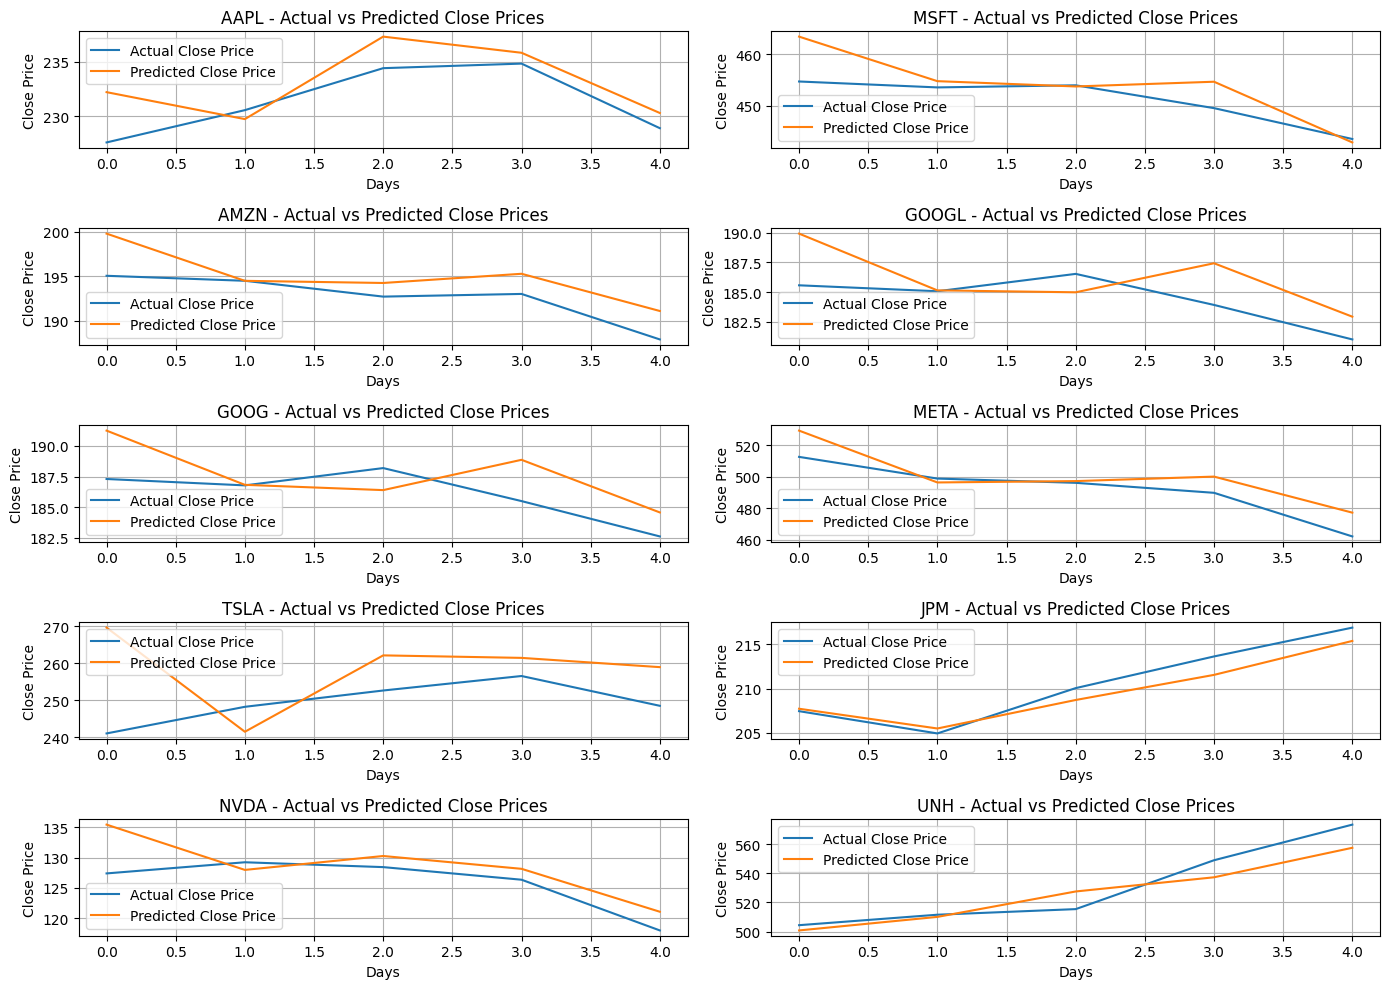

In [94]:
# Plot the actual vs predicted close prices for each stock
plt.figure(figsize=(14, 10))

for i, ticker in enumerate(tickers):
    plt.subplot(5, 2, i+1)
    plt.plot(actual_close_prices[ticker], label='Actual Close Price')
    plt.plot(predicted_close_prices[ticker], label='Predicted Close Price')
    plt.title(f'{ticker} - Actual vs Predicted Close Prices')
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()